In [51]:
import cv2
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from skimage import measure
from sklearn.decomposition import PCA

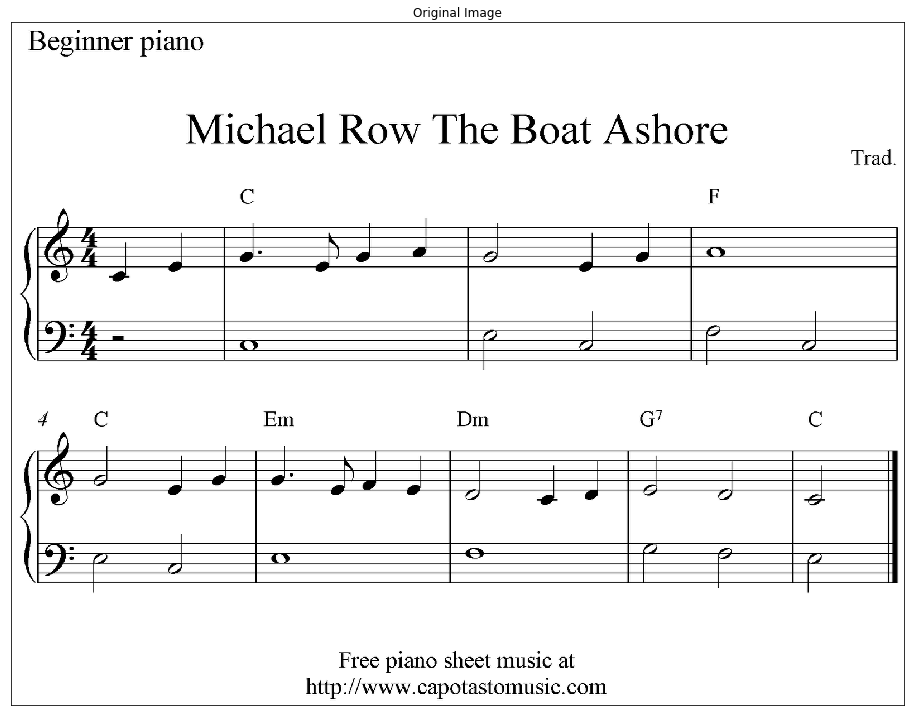

In [52]:
img = cv2.imread('Images/ss1.jpg', 0)

plt.figure(figsize=(16,16))
plt.imshow(img, cmap = 'gray')
plt.xticks([]), plt.yticks([])
plt.title('Original Image')
plt.show()

In [53]:
blur = cv2.GaussianBlur(img,(5,5),0)
thresh, img_bw = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

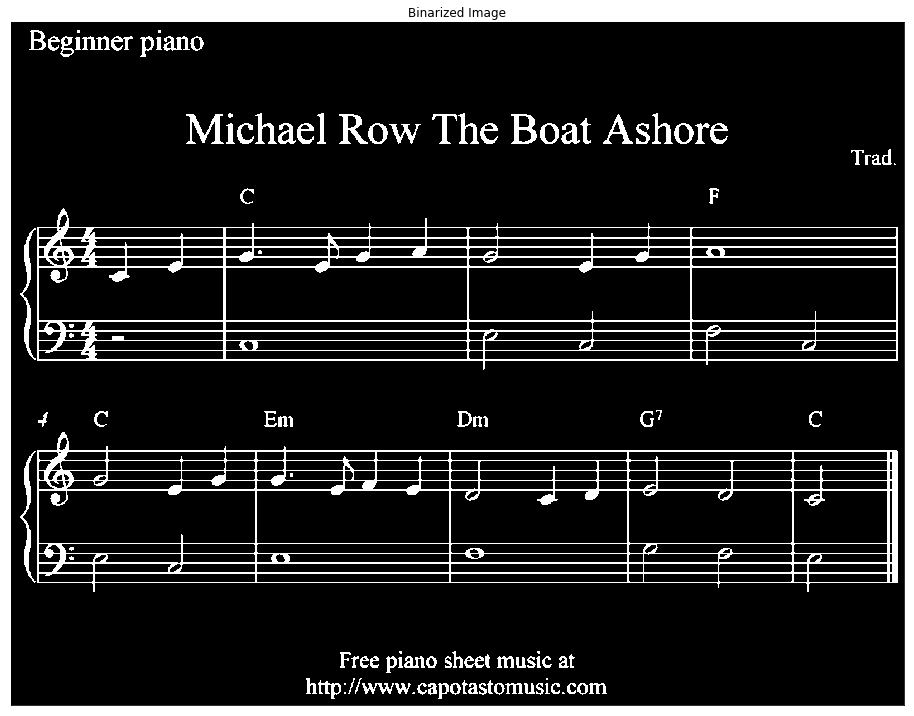

In [54]:
plt.figure(figsize=(16,16))
plt.imshow(img_bw, cmap = 'gray')
plt.xticks([]), plt.yticks([])
plt.title('Binarized Image')
plt.show()

In [55]:
def horizontal_projection(img):
    h,w = img.shape
    row_sum = []
    for i in range(h):
        row_sum.append(sum(img[i, 0:w]))
    return row_sum

In [56]:
def vertical_projection(img):
    h,w = img.shape
    col_sum = []
    for i in range(w):
        col_sum.append(sum(img[0:h, i]))
    return col_sum

In [57]:
row_sum = horizontal_projection(img_bw)
col_sum = vertical_projection(img_bw)

In [58]:
h,w = img.shape

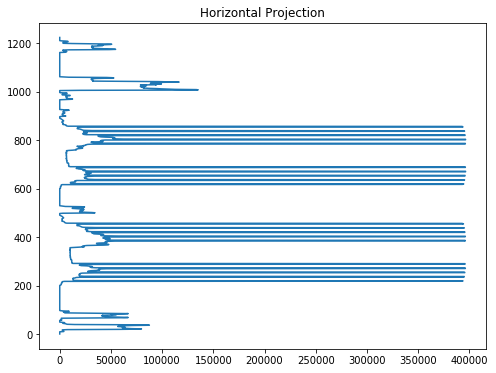

In [59]:
plt.figure(figsize=(8,6))
plt.plot(row_sum, range(h,0,-1))
plt.title('Horizontal Projection')
plt.show()

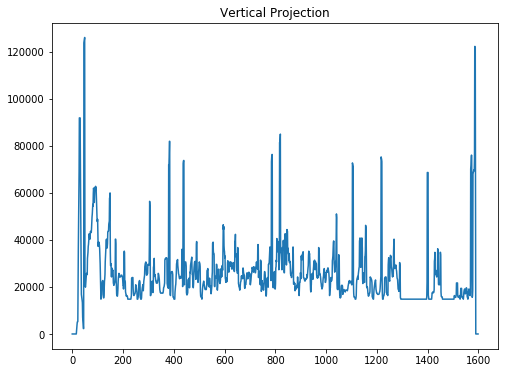

In [60]:
plt.figure(figsize=(8,6))
plt.plot(range(w), col_sum)
plt.title('Vertical Projection')
plt.show()

In [61]:
hp_max = max(row_sum)
for i in range(len(row_sum)):
    if row_sum[i] < 0.9*hp_max:
        row_sum[i] = 0

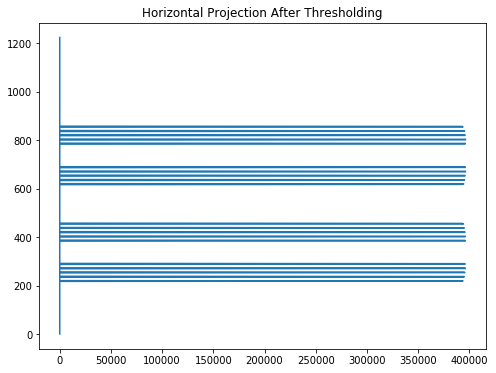

In [62]:
plt.figure(figsize=(8,6))
plt.plot(row_sum, range(h,0,-1))
plt.title('Horizontal Projection After Thresholding')
plt.show()

In [63]:
staff_lines = []
for i in range(len(row_sum)):
    if row_sum[i]>0:
        staff_lines.append(i)
len(staff_lines)

58

In [64]:
grand_stave_start = []
grand_stave_end = []

grand_stave_start.append(staff_lines[0])
for i in range(len(staff_lines)-1):
    if staff_lines[i+1]-staff_lines[i]>20:
        grand_stave_end.append(staff_lines[i])
        grand_stave_start.append(staff_lines[i+1])
grand_stave_end.append(staff_lines[i+1])
        
print(grand_stave_start)
print(grand_stave_end)

[367, 534, 767, 933]
[439, 606, 839, 1005]


In [65]:
grand_staves = []
for i in range(len(grand_stave_start)):
    grand_staves.append(img_bw[grand_stave_start[i]-40:grand_stave_end[i]+40])   

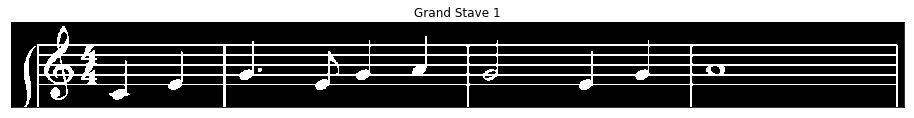

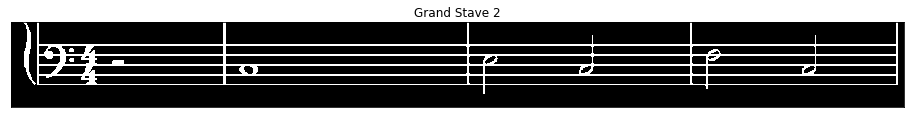

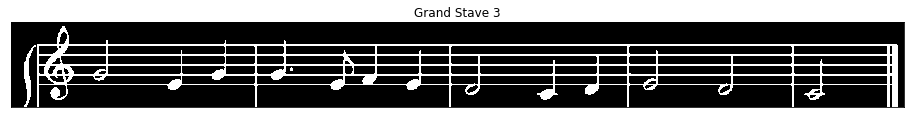

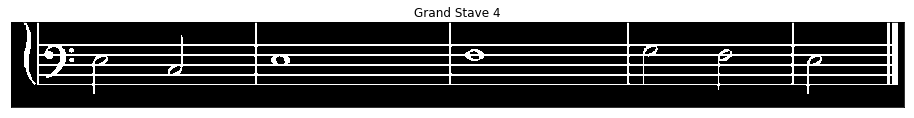

In [66]:
count=0
for i in grand_staves:
    count+=1
    plt.figure(figsize=(16,16))
    plt.imshow(i, cmap = 'gray')
    plt.xticks([]), plt.yticks([])
    plt.title('Grand Stave {}'.format(count))
    plt.show()

In [67]:
bar_dict = {}
bar_height_list = []
count=0

for i in grand_staves:
    print(i.shape)
    count+=1
#     plt.figure(figsize=(16,16))
#     plt.imshow(i, cmap = 'gray')
#     plt.xticks([]), plt.yticks([])
#     plt.title('Grand Stave {}'.format(count))
    
    col_sum = vertical_projection(i)
    vp_max = max(col_sum)
    bar_height_list.append(vp_max)
    bar_lines = []
    
    for j in range(len(col_sum)):
        if col_sum[j] < 0.9*vp_max:
            col_sum[j] = 0
        else:
            bar_lines.append(j)
    
    bar_dict[count-1] = bar_lines
    
#     plt.figure(figsize=(16,4))
#     plt.plot(range(w), col_sum)
#     plt.xticks([]), plt.yticks([])
#     plt.title('Vertical Projection for Grand Stave {}'.format(count))
#     plt.show()
bar_height_avg = int(np.mean(bar_height_list)/255)
print(bar_height_avg)
print(bar_dict)

(152, 1600)
(152, 1600)
(152, 1600)
(152, 1600)
112
{0: [46, 47, 48, 49, 380, 381, 382, 383, 384, 817, 818, 819, 820, 1217, 1218, 1219, 1220, 1586, 1587, 1588, 1589], 1: [46, 47, 48, 49, 380, 381, 382, 383, 384, 817, 818, 819, 820, 1217, 1218, 1219, 1220, 1586, 1587, 1588, 1589], 2: [46, 47, 48, 49, 437, 438, 439, 440, 785, 786, 787, 788, 1104, 1105, 1106, 1107, 1399, 1400, 1401, 1402, 1570, 1571, 1572, 1573, 1574, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588], 3: [46, 47, 48, 49, 437, 438, 439, 440, 785, 786, 787, 788, 1104, 1105, 1106, 1107, 1399, 1400, 1401, 1402, 1570, 1571, 1572, 1573, 1574, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588]}


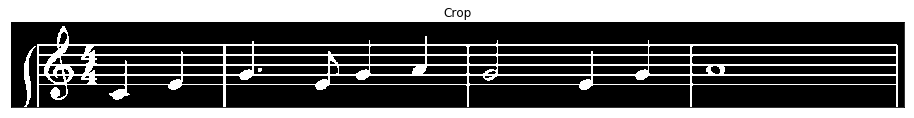

In [68]:
crop = img_bw[grand_stave_start[0]-40:grand_stave_end[0]+40]
crop_copy = crop.copy()
plt.figure(figsize=(16,9))
plt.imshow(crop, cmap = 'gray')
plt.xticks([]), plt.yticks([])
plt.title('Crop')
plt.show()

In [69]:
staff_lines_avg = []
temp = []

for i in range(len(staff_lines)-1):
    if staff_lines[i+1]-staff_lines[i]<2:
        temp.append(staff_lines[i])
        temp.append(staff_lines[i+1])
    else:
        staff_lines_avg.append(int(round(np.mean(list(set(temp))))))
        temp = []

staff_lines_avg.append(int(round(np.mean(list(set(temp))))))
len(staff_lines_avg)

20

In [70]:
# segmented_image = img_bw.copy()
# for i in staff_lines:
#     for j in range(w):
#         if sum(segmented_image[i-5:i+5, j])<1500:
#             segmented_image[i,j]=0

In [71]:
# plt.figure(figsize=(16,9))
# plt.imshow(segmented_image, cmap = 'gray')
# plt.xticks([]), plt.yticks([])
# plt.title('Line Removal')
# plt.show()

In [72]:
# from skimage import measure

# counter = 0

# segmented_image_transpose = segmented_image.transpose()
# labels = measure.label(segmented_image_transpose, neighbors=8, background=0)

# for label in np.unique(labels):
#     if label == 0:
#         continue

#     labelMask = np.zeros(segmented_image_transpose.shape, dtype="uint8")
#     labelMask[labels == label] = 255
    
#     note = labelMask.transpose()
#     numPixels = cv2.countNonZero(note)

#     if numPixels > 25:
#         x,y,w,h = cv2.boundingRect(note)
        
#         filename = 'Output/'+str(counter)+'.jpg'
#         crop_img = segmented_image[y:y+h, x:x+w]
#         cv2.imwrite(filename, crop_img)
#         counter += 1
        
#         cv2.rectangle(segmented_image,(x-5,y-5),(x+w+5,y+h+5),(255,255,255),2)
        
# plt.figure(figsize=(16,16))
# plt.imshow(segmented_image, cmap = 'gray')
# plt.xticks([]), plt.yticks([])
# plt.title('Detected Notes')
# plt.show()

In [73]:
def crop_notes(img, img_copy, counter=0):
    img_height, img_width = img.shape

    image_transpose = img.transpose()
    labels = measure.label(image_transpose, neighbors=8, background=0)

    for label in np.unique(labels):
        if label == 0:
            continue

        labelMask = np.zeros(image_transpose.shape, dtype="uint8")
        labelMask[labels == label] = 255

        note = labelMask.transpose()
        numPixels = cv2.countNonZero(note)

        if numPixels > 25:
            x,y,w,h = cv2.boundingRect(note)
            
            filename = 'Output/'+str(counter)+'.jpg'
            # crop_img = img_copy[y:y+bar_height_avg, x:x+w]
            crop_img = img_copy[0:img_height, x:x+w]
            cv2.imwrite(filename, crop_img)
            counter += 1
            cv2.rectangle(img,(x-5,y-5),(x+w+5,y+h+5),(255,255,255),2)

    plt.figure(figsize=(16,16))
    plt.imshow(img, cmap = 'gray')
    plt.xticks([]), plt.yticks([])
    plt.title('Detected Notes')
    plt.show()
    
    return counter

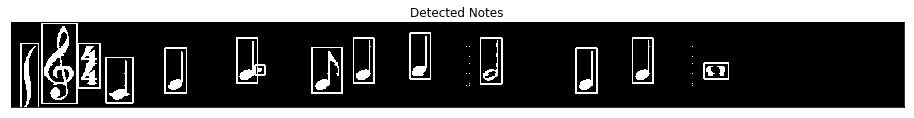

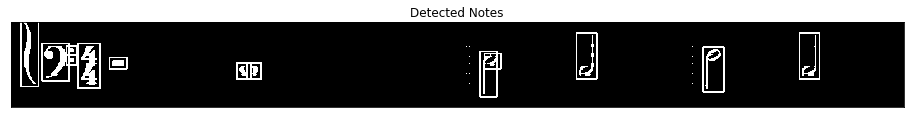

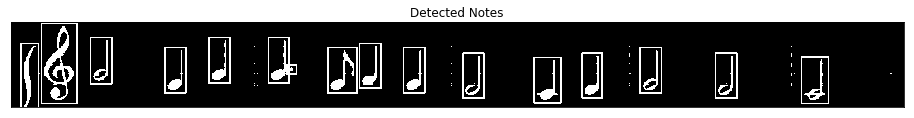

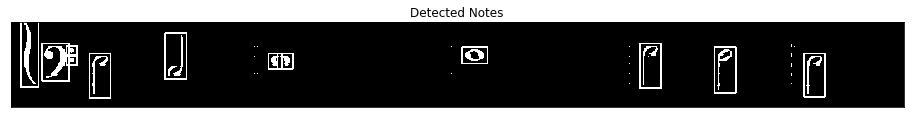

In [74]:
counter = 0
for k in grand_staves:
    img_copy = k.copy()
    
    row_sum = horizontal_projection(k)
    hp_max = max(row_sum)

    for i in range(len(row_sum)):
        if row_sum[i] < 0.9*hp_max:
            row_sum[i] = 0

    staff_lines = []
    for i in range(len(row_sum)):
        if row_sum[i]>0:
            staff_lines.append(i)

    for i in staff_lines:
        for j in range(w): 
            if sum(k[i-5:i+5, j])<1500:
                k[i,j]=0
    
    col_sum = vertical_projection(k)
    vp_max = max(col_sum)

    for i in range(len(col_sum)):
        if col_sum[i] < 0.9*vp_max:
            col_sum[i] = 0

    for i in range(w):
        if col_sum[i] != 0:
            k[:,i] = 0

    counter = crop_notes(k, img_copy, counter)

In [75]:
# for i in range(counter):
#     filename = 'Output/'+str(i)+'.jpg'
#     note_img = cv2.imread(filename, 0)
#     resized_img = cv2.resize(note_img, (20,20))
#     X = np.reshape(resized_img, (1, 400))